In [1]:
%pylab inline
# %env CUDA_VISIBLE_DEVICES=""

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

from keras import backend as K
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense
from keras.layers import BatchNormalization, Dropout
from keras.layers import Activation
from keras.callbacks import History, TensorBoard

from tools import load_household_power_consumption, augment
from tools import to_timeseries
from tools import split_train_test
from tools import vis_evaluate

from keras.utils.vis_utils import plot_model
from keras.utils.vis_utils import model_to_dot
from IPython.display import display
from IPython.display import SVG, Image

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


# Configuration

In [3]:
PREDICT_SIZE = 64
BATCH_SIZE = 2048

# Data

In [3]:
dataset, data_x, data_y = load_household_power_consumption()
train_x, train_y, test_x, test_y = split_train_test(data_x[:-PREDICT_SIZE], 
                                                    data_y[PREDICT_SIZE:], 
                                                    train_ratio=0.8)

# Data Augmentation
train_x = augment(train_x)
train_y = augment(train_y)

# Data Scaling
scaler_x = MinMaxScaler((0, 1))
scaler_y = MinMaxScaler((0, 1))

scaler_x = scaler_x.fit(np.concatenate((train_x, test_x)))
train_x = scaler_x.transform(train_x)
test_x = scaler_x.transform(test_x)

scaler_y = scaler_y.fit(np.concatenate((train_y, test_y)))
train_y = scaler_y.transform(train_y)
test_y = scaler_y.transform(test_y)

# To Timeseries dataset
train_x = to_timeseries(train_x, t=PREDICT_SIZE)
train_y = to_timeseries(train_y, t=PREDICT_SIZE)
test_x = to_timeseries(test_x, t=PREDICT_SIZE)
test_y = to_timeseries(test_y, t=PREDICT_SIZE)

print('data_x:', data_x.shape)
print('data_y:', data_y.shape)
print('train_x:', train_x.shape)
print('train_y:', train_y.shape)
print('test_x:', test_x.shape)
print('test_y:', test_y.shape)

2017-08-22 16:02:16,590 [hybrid-lstm.tool | INFO] Load existing dataset


data_x: (43642, 7)
data_y: (43642, 1)
train_x: (104459, 64, 7)
train_y: (104459, 64, 1)
test_x: (8589, 64, 7)
test_y: (8589, 64, 1)


In [4]:
dataset, data_x, data_y = load_household_power_consumption()

data_x = MinMaxScaler().fit_transform(data_x)
data_y = MinMaxScaler().fit_transform(data_y)

train_x, train_y, test_x, test_y = split_train_test(to_timeseries(data_x[:-PREDICT_SIZE], t=PREDICT_SIZE), 
                                                    to_timeseries(data_y[PREDICT_SIZE:], t=PREDICT_SIZE), 
                                                    train_ratio=0.8)
print('data_x:', data_x.shape)
print('data_y:', data_y.shape)
print('train_x:', train_x.shape)
print('train_y:', train_y.shape)
print('test_x:', test_x.shape)
print('test_y:', test_y.shape)

2017-08-22 16:10:01,237 [hybrid-lstm.tool | INFO] Load existing dataset


data_x: (43642, 7)
data_y: (43642, 1)
train_x: (34760, 64, 7)
train_y: (34760, 64, 1)
test_x: (8691, 64, 7)
test_y: (8691, 64, 1)


# Models

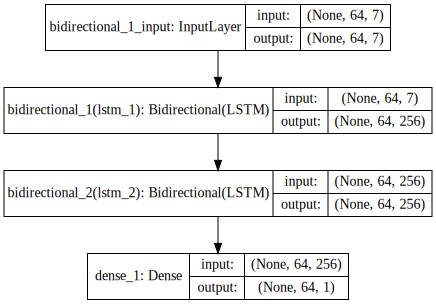

In [ ]:
def r2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def create_model(l1=64, l2=64):
    np.random.seed(0)
    model = Sequential()
    model.add(Bidirectional(LSTM(l1, return_sequences=True), input_shape=(PREDICT_SIZE, 7)))
    model.add(Bidirectional(LSTM(l1, return_sequences=True)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy', r2])
    return model

model = create_model(128, 128)
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# Training

In [ ]:
model = create_model(l1=128, l2=128)

history = History()
model.fit(train_x, train_y, epochs=100, batch_size=BATCH_SIZE, verbose=2, 
          validation_data=(test_x, test_y), callbacks=[history])

Train on 34760 samples, validate on 8691 samples
Epoch 1/100
11s - loss: 0.0186 - acc: 0.0000e+00 - r2: -7.7192e-01 - val_loss: 0.0102 - val_acc: 1.1506e-04 - val_r2: -9.1230e-02
Epoch 2/100
10s - loss: 0.0089 - acc: 0.0000e+00 - r2: 0.1506 - val_loss: 0.0082 - val_acc: 1.1506e-04 - val_r2: 0.1523
Epoch 3/100


In [5]:
model = create_model(l1=128, l2=128)

history = History()
model.fit(train_x, train_y, epochs=100, batch_size=BATCH_SIZE, verbose=2, 
          validation_data=(test_x, test_y), callbacks=[history])

Train on 34760 samples, validate on 8691 samples
Epoch 1/100
11s - loss: 0.0186 - acc: 0.0000e+00 - r2: -7.7192e-01 - val_loss: 0.0102 - val_acc: 1.1506e-04 - val_r2: -9.1230e-02
Epoch 2/100
9s - loss: 0.0089 - acc: 0.0000e+00 - r2: 0.1506 - val_loss: 0.0082 - val_acc: 1.1506e-04 - val_r2: 0.1523
Epoch 3/100
9s - loss: 0.0081 - acc: 0.0000e+00 - r2: 0.2286 - val_loss: 0.0083 - val_acc: 1.1506e-04 - val_r2: 0.1428
Epoch 4/100
9s - loss: 0.0079 - acc: 0.0000e+00 - r2: 0.2522 - val_loss: 0.0081 - val_acc: 1.1506e-04 - val_r2: 0.1696
Epoch 5/100


KeyboardInterrupt: 

In [ ]:
%time eval_results = model.evaluate(test_x, test_y, batch_size=BATCH_SIZE, verbose=2)

for k, v in zip(model.metrics_names, eval_results):
    print(f'{k}: {v}')

In [ ]:
vis_evaluate(model, test_x, test_y)